<a href="https://colab.research.google.com/github/devanaazzahra/MTDFS/blob/main/tugas13_mtfd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/devanaazzahra/MTDFS/main/data.csv");
data = pd.DataFrame(data=dataset.iloc[:, [2,3,4]], columns=['radius_mean', 'texture_mean', 'perimeter_mean'])

target = ['B', 'M']

temp = [];

for x in dataset['diagnosis']:
  if(x == 'B'): 
      temp.append(0)
  else:
      temp.append(1)

labels = temp


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
print(data)

     radius_mean  texture_mean  perimeter_mean
0       0.521037      0.022658        0.545989
1       0.643144      0.272574        0.615783
2       0.601496      0.390260        0.595743
3       0.210090      0.360839        0.233501
4       0.629893      0.156578        0.630986
..           ...           ...             ...
564     0.690000      0.428813        0.678668
565     0.622320      0.626987        0.604036
566     0.455251      0.621238        0.445788
567     0.644564      0.663510        0.665538
568     0.036869      0.501522        0.028540

[569 rows x 3 columns]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = principalComponents , columns = [
    'principal component 1', 
    'principal component 2',
    'principal component 3'
    ])

print(PCAdf)

datapoints = PCAdf.values
m, f = datapoints.shape
k = 3

     principal component 1  principal component 2  principal component 3
0                 0.183291              -0.368111               0.022314
1                 0.384024              -0.166979              -0.016303
2                 0.375547              -0.041693              -0.001540
3                -0.143824               0.080993               0.020472
4                 0.352596              -0.278534               0.004423
..                     ...                    ...                    ...
564               0.502705              -0.039039              -0.005969
565               0.462252               0.179488              -0.011692
566               0.240019               0.239102              -0.004891
567               0.529487               0.197881               0.015737
568              -0.360579               0.291505              -0.002090

[569 rows x 3 columns]


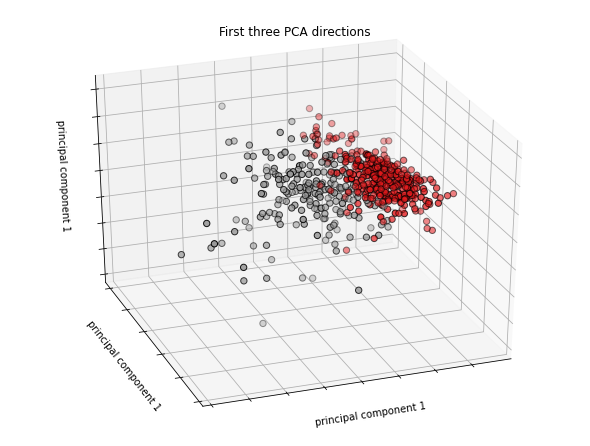

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = datapoints
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("principal component 1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("principal component 1")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("principal component 1")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [ ]:
def init_medoids(X, k):
    from numpy.random import choice
    from numpy.random import seed
 
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

medoids_initial = init_medoids(datapoints, 3)

def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    # If a 1-D array is provided, 
    # it will be reshaped to a single row 2-D array
    if len(medoids_shape) == 1: 
        medoids = medoids.reshape((1,len(medoids)))
    k = len(medoids)
    
    S = np.empty((m, k))
    
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i**p

    return S
  
S = compute_d_p(datapoints, medoids_initial, 2)


def assign_labels(S):
    return np.argmin(S, axis=1)
  
labels = assign_labels(S)

def update_medoids(X, medoids, p):
    
    S = compute_d_p(datapoints, medoids, p)
    labels = assign_labels(S)
        
    out_medoids = medoids
                
    for i in set(labels):
        
        avg_dissimilarity = np.sum(compute_d_p(datapoints, medoids[i], p))

        cluster_points = datapoints[labels == i]
        
        for datap in cluster_points:
            new_medoid = datap
            new_dissimilarity= np.sum(compute_d_p(datapoints, datap, p))
            
            if new_dissimilarity < avg_dissimilarity :
                avg_dissimilarity = new_dissimilarity
                
                out_medoids[i] = datap
                
    return out_medoids

def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])
  
#Full algorithm
def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()
        
        S = compute_d_p(X, medoids, p)
        
        labels = assign_labels(S)
        
        medoids = update_medoids(X, medoids, p)
        
        converged = has_converged(old_medoids, medoids)
        i += 1
    return (medoids,labels)

results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

#Count
def mark_matches(a, b, exact=False):
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1) | (a_int == 2)).all()
    assert ((b_int == 0) | (b_int == 1) | (b_int == 2)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod (a.shape):
        return exact_matches
    return exact_matches == False # Invert

def count_matches(a, b, exact=False):
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)

n_matches = count_matches(labels, data['clusters'])

print(n_matches,
      "matches out of",
      len(data), "data points",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(labels)))

354 matches out of 569 data points (~ 62.2%)
